# KNNFuzz Wrap-up & How to use it

## Structure of the code
```txt
FuzzSIM/
│── fuzz/            
│   ├── choquet/
│   │   ├── __init__.py
│   │   ├── choquet.py
│   │   ├── classic.py      
│   │   ├── d_choquet.py  
│   │   ├── linear_d_choquet.py  
│   ├── src/     
│   │   ├── __init__.py
│   │   ├── base.py 
│   │   ├── knn.py              
│   │   ├── norm.py              
│   │   ├── sim.py              
│   ├── __init__.py
│   ├── set.py              
│   ├── dataloader.py              
│   ├── eval.py    
│   ├── optim.py
│   ├── utils.py 
│── scripts/                
│   ├── setup_env.sh     
│── __init__.py
│── requirements.txt
│── LICENSE
│── README.md                      
```
### About Choquet Integral
Currently, we've implemented 3 methods for computing the Choquet integral:
- `classic.py`: Classic fuzzy measure.
- `d_choquet.py`: d-Choquet integral. The formula is given by:
    $$
    \mathbb{C}_{\nu, \delta}(X)=\sum_{i=1}^{n} \delta(X(\sigma(i)), X(\sigma(i-1))) \cdot \nu(\{\sigma(i), ..., \sigma(n)\})
    $$
- `linear_d_choquet.py`: Linear d-Choquet integral.
    $$
    \mathbb{C}[X]=\sum^n_{i=1}\mu_i\left[\sum_{x_j\leq x_i} \delta(x_j, \max\{x_k:x_k\leq x_j\}_{j\neq k})\right]+\sum_{i<j}\mu_{ij}\left[\sum_{x_k\leq\min\{x_i,x_j\}}\delta\left(x_k, \max\{x_h: x_h\leq x_k\}_{h\neq k}\right)\right]
    $$

The `choquet.py` file contains the Choquet integral class, which can be used to compute the Choquet integral using any of the above methods.

### About FuzzSIM
FuzzSIM is a class implementing different methods for computing the similarity between sets. We differ 3 levels of similarity, which are: 

- Similarity level 1: 

    $$
    \mathbf{S}_1^{\nu, \delta}(X, Y)=\frac{\mathbb{C}_{\nu, \delta}(X\cap Y)}{\mathbb{C}_{\nu, \delta}(X\backslash Y) + \mathbb{C}_{\nu, \delta}(Y\backslash X) + \mathbb{C}_{\nu, \delta}(X\cap Y)}
    $$

### About KNNFuzz
KNNFuzz is a variant of the KNN algorithm. The idea is instead of using the standard distance metric, we use the Choquet integral to compute the similarity between sets. Using similarity to explain the ressemblance between sets makes it easier to understand the results of the algorithm. The KNNFuzz algorithm is implemented in the `knn.py` file.

---


## Setup environment
Simplest way to setup the environment is to run the `setup_env.sh` script, you will need to switch to the newly created kernel to use it. 

Otherwise, to be more safe, you can run the following commands to install the required packages:
```bash
# Create a conda environment with compatible python version (3.10)
conda create -n fuzzsim python=3.10 -y

# Activate the environment
conda activate fuzzsim

# Optional: upgrade pip
pip install --upgrade pip

# Install other dependencies
pip install -r requirements.txt
```

In [ ]:
# environment setup 
!chmod +x scripts/setup_env.sh
!./scripts/setup_env.sh

---
## Main demo

### Import libraries

In [2]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [3]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

### Dataloader

There are 2 ways to prepare data for the KNNFuzz algorithm:
1. Use `dynamic_generate_positive_gaussian_data` to dynamically generate a dataset of positive Gaussian data.
2. Use specific datasets, such as `iris`, `penguins`, etc.

The following cell with allow us to generate a complete positive Gaussian dataset, with 3 dimensions, 3 labels, and 100 points per class, using seed 42 for reproducibility. We use `batch_norm` to normalize the data to [0, 1] range.

In [4]:
data, labels = dynamic_generate_positive_gaussian_data(
    dim=3,
    nb_classes=3,
    nb_points_per_class=100,
    seed=42
)
data = batch_norm(data)
data[:5]

array([[0.        , 1.        , 0.01959192],
       [1.        , 0.        , 0.4070175 ],
       [0.        , 0.38090406, 1.        ],
       [0.6965442 , 0.        , 1.        ],
       [0.        , 1.        , 0.99405304]])

As we can see, our generated dataset is well normalized and ready to be used with the KNNFuzz algorithm. 

Or, to use the `iris` dataset, you can run the following cell: 

In [5]:
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))
data[:5]

array([[1.        , 0.67346936, 0.24489795, 0.        ],
       [1.        , 0.59574461, 0.25531912, 0.        ],
       [1.        , 0.66666669, 0.24444443, 0.        ],
       [1.        , 0.65909088, 0.29545453, 0.        ],
       [1.        , 0.70833325, 0.24999997, 0.        ]])

To generated train-test dataset and labels for cross-validation, we can use the `dataloader` module. The following cell will generate a train-test split with 80% of the data for training and 20% for testing, using the `iris` dataset as an example.

After the execution, we should obtain 80% of the data from each class for training and 20% for testing, with the labels corresponding to the classes of the data points.

In [7]:
train_data, train_labels, test_data, test_labels = crossval((data, labels))
print("Original data shape:", data.shape)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Original data shape: (150, 4)
Train data shape: (120, 4)
Test data shape: (30, 4)


### Base functions

In [14]:
# To enumerate all the possible combinations of the choquet capacity
enumerated_data = enumerate_permute_unit(data[0])
print("Enumerated data shape:", len(enumerated_data))
print("Enumerated data:", enumerated_data)

Enumerated data shape: 16
Enumerated data: [[], [3], [2], [1], [0], [3, 2], [3, 1], [3, 0], [2, 1], [2, 0], [1, 0], [3, 2, 1], [3, 2, 0], [3, 1, 0], [2, 1, 0], [3, 2, 1, 0]]


In [19]:
# To generate the choquet capacity from the enumerated data
mu=generate_capacity(enumerate_permute_unit(data[0]))
print("Generated capacity shape:", len(mu))
for i in range(len(mu)):
    print(f"mu[{i}]: {mu[i].mu}")

Generated capacity shape: 16
mu[0]: 0
mu[1]: 0.032315951109650465
mu[2]: 0.07620037959916315
mu[3]: 0.08274842003530614
mu[4]: 0.1331851252237497
mu[5]: 0.2599498628542627
mu[6]: 0.2709576425151299
mu[7]: 0.2797635071689457
mu[8]: 0.41120672087218624
mu[9]: 0.4166390577384792
mu[10]: 0.45324084682883103
mu[11]: 0.5811626211808263
mu[12]: 0.6027818820232985
mu[13]: 0.9191765518355596
mu[14]: 0.9405318271353834
mu[15]: 1


### Choquet calculation

In [23]:
for i in range(5):
    choquet = Choquet(X=data[i], mu=mu, version='classic', p=1, q=1)
    print(f"Choquet capacity for data point {i}: {choquet.choquet}")

Choquet capacity for data point 0: 0.46602470882356795
Choquet capacity for data point 1: 0.4314854925133812
Choquet capacity for data point 2: 0.46256467447972033
Choquet capacity for data point 3: 0.4751991256353589
Choquet capacity for data point 4: 0.4846464993848833


In [24]:
for i in range(5):
    choquet = Choquet(X=data[i], mu=mu, version='d_choquet', p=1, q=1)
    print(f"Choquet capacity for data point {i}: {choquet.choquet}")

Choquet capacity for data point 0: 1.8602821826934814
Choquet capacity for data point 1: 1.7486162185668945
Choquet capacity for data point 2: 1.8509459495544434
Choquet capacity for data point 3: 1.8240609169006348
Choquet capacity for data point 4: 1.9072415828704834


In [25]:
for i in range(5):
    choquet = Choquet(X=data[i], mu=mu, version='linear', p=1, q=1)
    print(f"Choquet capacity for data point {i}: {choquet.choquet}")

Choquet capacity for data point 0: 0.5489344383459226
Choquet capacity for data point 1: 0.5169202893619437
Choquet capacity for data point 2: 0.5453633334110348
Choquet capacity for data point 3: 0.5704009158295766
Choquet capacity for data point 4: 0.5688009248012695


### Similarity calculation

In [30]:
for i in range(5):
    y_idx = np.random.randint(0, 10)
    sim = S1(X=data[i], Y=data[y_idx], mu=mu)
    print(f"Similarity score for data points {i} and {y_idx}: {sim.score()}")

Similarity score for data points 0 and 1: 0.4417347026492251
Similarity score for data points 1 and 8: 0.4302613016695984
Similarity score for data points 2 and 2: 0.46854534723381636
Similarity score for data points 3 and 0: 0.465395668196634
Similarity score for data points 4 and 4: 0.5020115548336678


In [ ]:
for i in range(5):
    y_idx = np.random.randint(0, 10)
    sim = S2(X=data[i], Y=data[y_idx], mu=mu)
    print(f"Similarity score for data points {i} and {y_idx}: {sim.score()}")

# S2 is the best similarity measure for the choquet capacity (as observed)

Similarity score for data points 0 and 6: 0.5144487486570971
Similarity score for data points 1 and 5: 0.4889139405461944
Similarity score for data points 2 and 0: 0.5041433540668973
Similarity score for data points 3 and 4: 0.5021409067545958
Similarity score for data points 4 and 4: 1.0


In [32]:
for i in range(5):
    y_idx = np.random.randint(0, 10)
    sim = S3(X=data[i], Y=data[y_idx], mu=mu)
    print(f"Similarity score for data points {i} and {y_idx}: {sim.score()}")

Similarity score for data points 0 and 5: 0.6108751141872459
Similarity score for data points 1 and 2: 0.57386317734446
Similarity score for data points 2 and 4: 0.6126716139730615
Similarity score for data points 3 and 6: 0.6048868367689412
Similarity score for data points 4 and 4: 0.6261852828546677


### KNNFuzz sample usage

In [33]:
KNN = KNNFuzz(input_dimension=4, mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1)
KNN.train(data, labels)

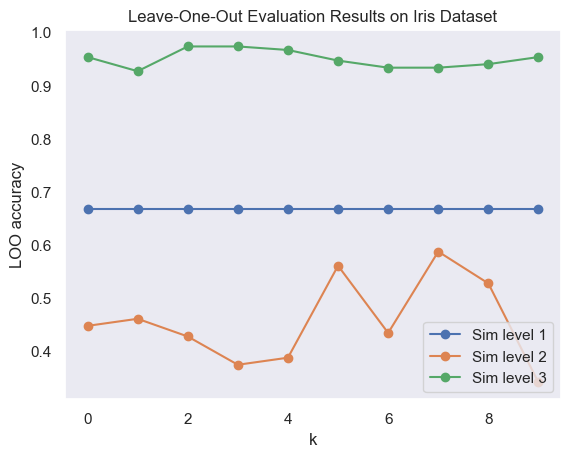

In [36]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = generate_capacity(enumerate_permute_unit(data[0]))

    # print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1], mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l1.append(res)
    # print(f"SimLevel1: {res}")
    # Sim level 2
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S2, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l2.append(res)
    # print(f"SimLevel2: {res}")

    # Sim level 3
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S3, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l3.append(res)
    # print(f"SimLevel3: {res}\n")

    toc = time.time()
    # print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results on Iris Dataset")
plt.grid()
plt.legend()

---